## close value avec Linear Regression, Random Forest Regressor, XGBoost Regressor

In [94]:
# Importation des bibliothèques nécessaires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import shap


In [95]:
# Charger les données
df = pd.read_csv("C:/Users/zineb/OneDrive/Bureau/hetic/DA/silver/data_clean.csv")




In [96]:
# Remplacer les virgules par des points si nécessaire
df['revenue'] = df['revenue'].str.replace(',', '.', regex=True)

# Convertir la colonne revenue en type float
df['revenue'] = pd.to_numeric(df['revenue'], errors='coerce').astype(float)


# verification des colonnes engage_at et close_at sont au format datetime
df['engage_at'] = pd.to_datetime(df['engage_at'], errors='coerce')
df['close_at'] = pd.to_datetime(df['close_at'], errors='coerce')

# Remplir les valeurs de close_value avec 0 pour les états engaging, prospecting, et lost
df.loc[df['deal_stage'].isin(['engaging', 'prospecting', 'lost']), 'close_value'] = 0



# Calculer la marge commerciale (sales_margin)
df['sales_margin'] = df.apply(
    lambda row: 0 if row['close_value'] == 0 else row['close_value'] - row['sales_price'],
    axis=1
)

# Créer des colonnes temporelles dérivées

df['engage_month'] = df['engage_at'].dt.month
df['engage_day'] = df['engage_at'].dt.day
df['engage_weekday'] = df['engage_at'].dt.weekday  # Lundi=0, Dimanche=6



# Calcul de la durée du cycle de vente (sales_cycle_days)
df['sales_cycle_days'] = (df['close_at'] - df['engage_at']).dt.days

# Remplir les valeurs manquantes

df['sales_cycle_days'] = df['sales_cycle_days'].fillna(0)




# Vérifier les valeurs manquantes dans sales_margin
print("Nombre de NaN dans sales_margin avant traitement :", df['sales_margin'].isnull().sum())

# Remplacer les NaN dans sales_margin par 0
df['sales_margin'] = df['sales_margin'].fillna(0)

# Vérifier à nouveau pour s'assurer qu'il n'y a plus de NaN
print("Nombre de NaN dans sales_margin après traitement :", df['sales_margin'].isnull().sum())


# Afficher les premières lignes pour vérifier
print(df[['close_value', 'sales_price', 'sales_margin', 'sales_cycle_days']].head())




nombre_de_lignes = (df['sales_margin'] < 0).sum()
print(f"Nombre de lignes où sales_margin < 0 : {nombre_de_lignes}")





Nombre de NaN dans sales_margin avant traitement : 664
Nombre de NaN dans sales_margin après traitement : 0
   close_value  sales_price  sales_margin  sales_cycle_days
0          0.0          550           0.0               7.0
1          0.0          550           0.0              13.0
2          0.0          550           0.0              69.0
3          0.0          550           0.0               2.0
4          0.0          550           0.0               2.0
Nombre de lignes où sales_margin < 0 : 2133


C:\Users\zineb\AppData\Local\Temp\ipykernel_27132\3881255125.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['engage_at'] = pd.to_datetime(df['engage_at'], errors='coerce')
C:\Users\zineb\AppData\Local\Temp\ipykernel_27132\3881255125.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['close_at'] = pd.to_datetime(df['close_at'], errors='coerce')


In [97]:
# 'sales_agent', 'product', 'account', 'sector', 'series', 'sales_price','manager', 'office_location', 'regional_office', 'revenue','number_of_employees', 'sales_margin'

# Gestion des colonnes pertinentes
columns = [
    'sector', 'product', 'account', 'sales_agent', 'regional_office',  'manager',
    'sales_price', 'revenue', 'series', 'office_location', 'number_of_employees'
]
target = 'close_value'  # La variable cible
df = df[columns + [target]]



In [98]:
# Encodage des variables catégoriques
categorical_columns = ['sector', 'product', 'account', 'sales_agent', 'regional_office', 'series', 'office_location','manager']
label_encoders = {}

for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le



In [99]:
# Conversion des colonnes numériques
df['sales_price'] = pd.to_numeric(df['sales_price'], errors='coerce')
df['revenue'] = pd.to_numeric(df['revenue'], errors='coerce')

# Gestion des valeurs manquantes
df = df.fillna(df.mean())



In [100]:
# Séparation des données
X = df.drop(columns=[target])
y = df[target]



In [101]:
# Division en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [102]:
# Normalisation des données
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



In [103]:
# Modèles de régression
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest Regressor": RandomForestRegressor(random_state=42, n_estimators=100),
    "XGBoost Regressor": XGBRegressor(random_state=42, n_estimators=100)
}



In [104]:
# Entraînement et évaluation des modèles
results = []
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    results.append({'Model': name, 'R²': r2, 'MAE': mae, 'RMSE': rmse})
    print(f"--- {name} ---")
    print(f"R² Score: {r2:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print()

--- Linear Regression ---
R² Score: 0.35
MAE: 1162.35
RMSE: 1696.97

--- Random Forest Regressor ---
R² Score: 0.16
MAE: 1166.76
RMSE: 1927.49

--- XGBoost Regressor ---
R² Score: 0.17
MAE: 1169.90
RMSE: 1916.21



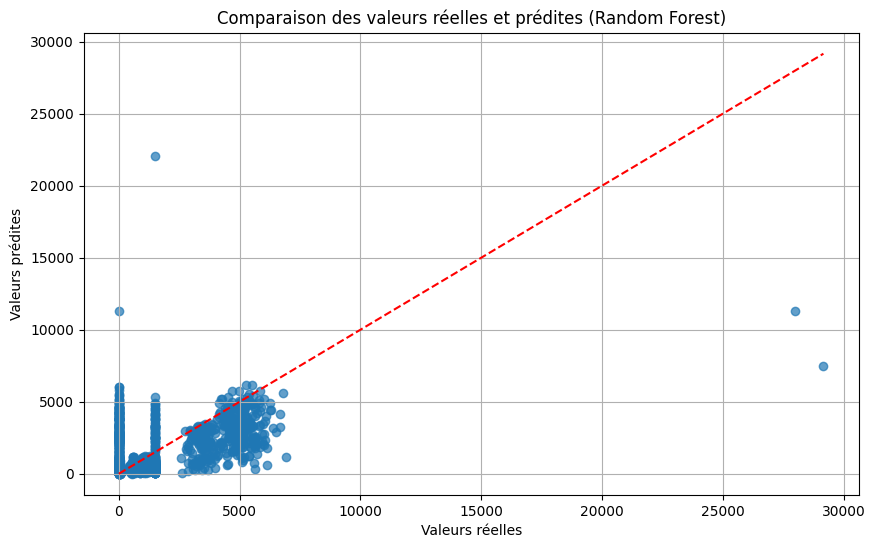

: 

In [ ]:
best_model = models["Random Forest Regressor"]  # Exemple : choisir le modèle préféré
y_pred_best = best_model.predict(X_test_scaled)

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_best, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title("Comparaison des valeurs réelles et prédites (Random Forest)")
plt.xlabel("Valeurs réelles")
plt.ylabel("Valeurs prédites")
plt.grid()
plt.show()

                     Model        R²          MAE         RMSE
0        Linear Regression  0.351462  1162.354650  1696.969138
1  Random Forest Regressor  0.163299  1166.761787  1927.486869
2        XGBoost Regressor  0.173061  1169.895862  1916.208565


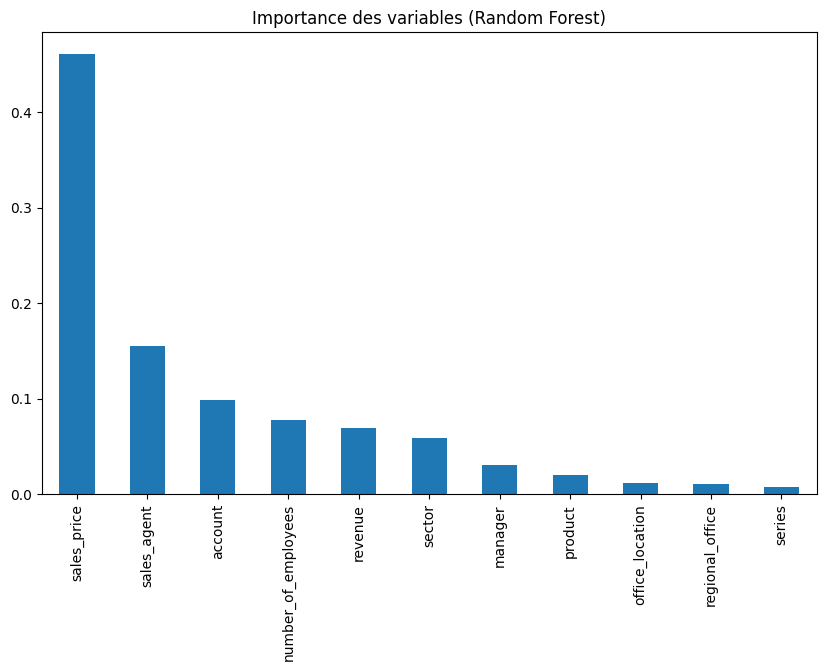

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Meilleurs paramètres (Random Forest): {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 200}
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Meilleurs paramètres (XGBoost): {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


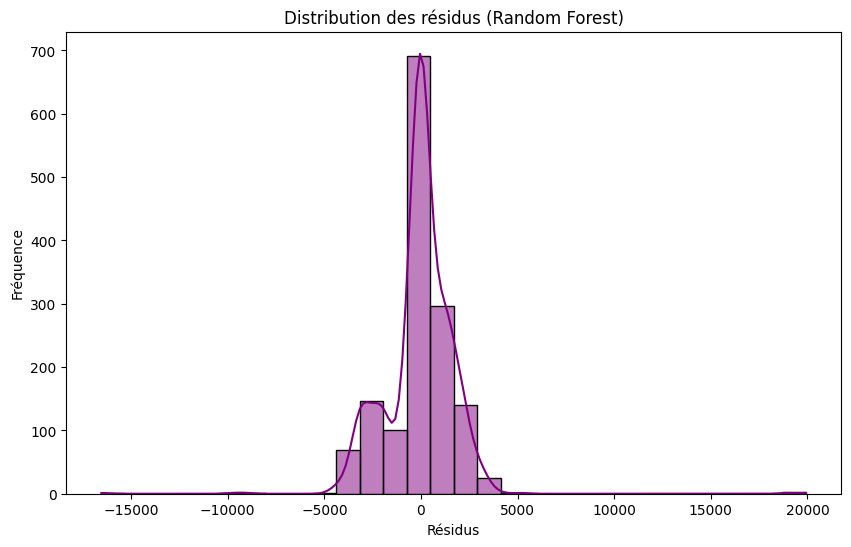

 97%|=================== | 1434/1475 [00:27<00:00]       

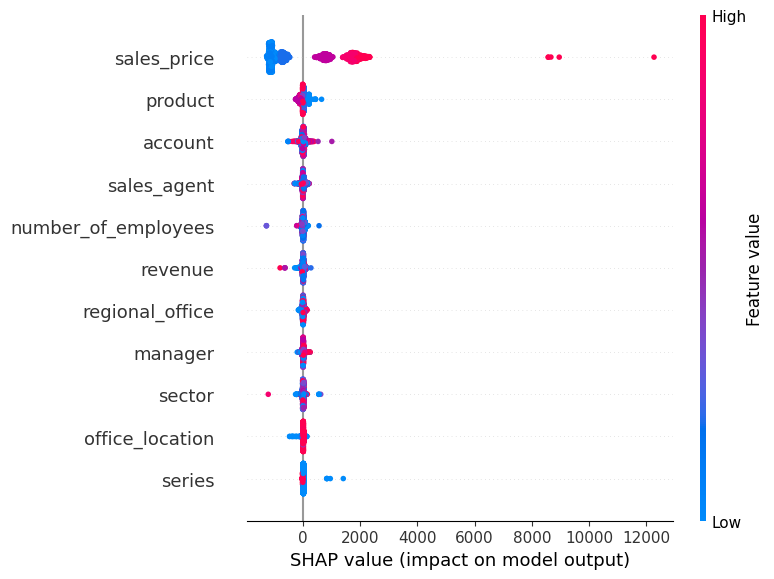

In [93]:
# %% Visualisation des performances des modèles
results_df = pd.DataFrame(results)
print(results_df)

# %% Importance des variables pour Random Forest
best_model = models["Random Forest Regressor"]
importances = pd.Series(best_model.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
importances.plot(kind='bar')
plt.title("Importance des variables (Random Forest)")
plt.show()

# %% Optimisation des hyperparamètres avec GridSearchCV (Random Forest)
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}
grid_rf = GridSearchCV(RandomForestRegressor(random_state=42), param_grid_rf, cv=3, scoring='r2', verbose=1)
grid_rf.fit(X_train_scaled, y_train)

print("Meilleurs paramètres (Random Forest):", grid_rf.best_params_)
best_rf_model = grid_rf.best_estimator_

# %% Optimisation des hyperparamètres avec GridSearchCV (XGBoost)
param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 10]
}
grid_xgb = GridSearchCV(XGBRegressor(random_state=42), param_grid_xgb, cv=3, scoring='r2', verbose=1)
grid_xgb.fit(X_train_scaled, y_train)

print("Meilleurs paramètres (XGBoost):", grid_xgb.best_params_)
best_xgb_model = grid_xgb.best_estimator_

# %% Analyse des résidus (Random Forest)
y_pred_rf = best_rf_model.predict(X_test_scaled)
residuals = y_test - y_pred_rf

plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=30, color='purple')
plt.title("Distribution des résidus (Random Forest)")
plt.xlabel("Résidus")
plt.ylabel("Fréquence")
plt.show()


# Explicabilité des modèles avec SHAP
explainer = shap.Explainer(best_rf_model, X_test_scaled)
shap_values = explainer(X_test_scaled, check_additivity=False)

# Affichage des explications SHAP
shap.summary_plot(shap_values, X_test_scaled, feature_names=X.columns)
